In [1]:
import numpy as np
import pandas as pd
import subprocess
import json
import matplotlib.pyplot as plt
import seaborn as sns
from apxinfer.simulation import utils as simutils
from apxinfer.simulation.utils import task_meta
from apxinfer.examples.all_tasks import ALL_CLS_TASKS, ALL_REG_TASKS

task_name = "tripsralfv3"
task_name = "machineryralf"
model = task_meta[task_name]['model']
agg_qids = task_meta[task_name]['agg_ids']

cmd = f"cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp {task_name} --model {model} --phase biathlon-policy"
result = subprocess.run(cmd, capture_output=True, text=True, shell=True, check=True)
result

/home/ckchang/anaconda3/envs/apx/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-27 16:58:41,266	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


CompletedProcess(args='cd /home/ckchang/ApproxInfer/apxinfer/examples && python evaluate_all.py --exp machineryralf --model mlp --phase biathlon-policy', returncode=0, stdout='skip /home/ckchang/.cache/biathlon/vldb2024/final/machineryralf/seed-0/online/mlp/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizer-5-8/evals_conf-0.05-0.0-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/machineryralf/seed-0/online/mlp/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpinit-5-8/evals_conf-0.05-0.0-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/machineryralf/seed-0/online/mlp/ncores-1/ldnthreads-0/nparts-100/ncfgs-100/pest-error-biathlon-128-0/qinf-biathlon/scheduler-optimizerexpbatch-5-8/evals_conf-0.05-0.0-0.95-60.0-2048.0-1000.json\nskip /home/ckchang/.cache/biathlon/vldb2024/final/machineryralf/seed-0/online/mlp/ncores-1/ldnthre

In [2]:
stdout = result.stdout
eval_paths = [s.replace('skip ', '') for s in stdout.split('\n')]
eval_paths = [p for p in eval_paths if p != '']

In [3]:
data = []
for path in eval_paths:
    with open(path, 'r') as f:
        item = {}
        settings = path.split('/')
        for setting in settings:
            if setting.startswith('pest'):
                item['pest'] = setting.split('-')[2]
            elif setting.startswith('qinf'):
                item['qinf'] = setting.split('-')[1]
            elif setting.startswith('scheduler'):
                item['scheduler'] = setting.split('-')[1]
        evals = json.load(f)
        acc_metric = 'r2' if task_name in ALL_REG_TASKS else 'f1'
        item = {**item,
            'accuracy': evals['evals_to_gt'][acc_metric],
            'similarity': evals['evals_to_ext'][acc_metric],
            'latency': evals['avg_ppl_time'],
            'qtime': evals['avg_query_time'],
            'overhead': evals['avg_pred_time'] + evals['avg_scheduler_time'],
            'avg_samples': np.mean(np.array(evals['avg_sample_query'])[agg_qids])
        }
        data.append(item)

In [4]:
df = pd.DataFrame(data)
df['policy'] = df['pest'] + '-' + df['qinf'] + '-' + df['scheduler']
df = df.sort_values(['pest', 'qinf', 'scheduler'])
df.set_index(['pest', 'qinf', 'scheduler'], inplace=True)
# dedup
df = df[~df.index.duplicated(keep='first')]
df

accuracy  similarity   latency  \
pest     qinf         scheduler                                           
MC       prevgradient optimizer          0.961672    0.996599  0.628569   
                      stepgradient       0.961672    0.996599  0.496097   
         yufei        optimizer          0.961672    1.000000  0.618393   
                      stepgradient       0.959860    0.998296  0.474916   
biathlon biathlon     optimizer          0.959860    0.998296  0.258448   
                      optimizerexpbatch  0.958042    0.996587  0.265193   
                      optimizerexpinit   0.958042    0.996587  0.427135   
                      random             0.961672    1.000000  0.356152   
                      stepgradient       0.961672    1.000000  0.281323   
                      uniform            0.961672    1.000000  0.300526   
                      uniformexpbatch    0.961672    1.000000  0.359262   
                      uniformexpinit     0.961672    1.000000  0.311116   
         prevgradient optimizer          0.961672    0.996599  1.376000   
                      stepgradient       0.961672    0.996599  1.134327   
         yufei        optimizer          0.959860    0.998296  1.408750   
                      stepgradient       0.958042    0.996587  1.090429   

                                            qtime  overhead  avg_samples  \
pest     qinf         scheduler                                            
MC       prevgradient optimizer          0.468029  0.156904     0.141923   
                      stepgradient       0.379209  0.114013     0.117130   
         yufei        optimizer          0.461063  0.153785     0.140740   
                      stepgradient       0.366528  0.105662     0.113284   
biathlon biathlon     optimizer          0.203125  0.054081     0.072130   
                      optimizerexpbatch  0.246940  0.017500     0.088491   
                      optimizerexpinit   0.408766  0.017616     0.101923   
                      random             0.296273  0.056810     0.089231   
                      stepgradient       0.223359  0.056608     0.072544   
                      uniform            0.286375  0.013138     0.103787   
                      uniformexpbatch    0.347452  0.010994     0.129527   
                      uniformexpinit     0.298784  0.011432     0.110799   
         prevgradient optimizer          0.446170  0.926611     0.129763   
                      stepgradient       0.383711  0.747924     0.112041   
         yufei        optimizer          0.452739  0.952673     0.132988   
                      stepgradient       0.371758  0.715953     0.110858   

                                                                      policy  
pest     qinf         scheduler                                               
MC       prevgradient optimizer                    MC-prevgradient-optimizer  
                      stepgradient              MC-prevgradient-stepgradient  
         yufei        optimizer                           MC-yufei-optimizer  
                      stepgradient                     MC-yufei-stepgradient  
biathlon biathlon     optimizer                  biathlon-biathlon-optimizer  
                      optimizerexpbatch  biathlon-biathlon-optimizerexpbatch  
                      optimizerexpinit    biathlon-biathlon-optimizerexpinit  
                      random                        biathlon-biathlon-random  
                      stepgradient            biathlon-biathlon-stepgradient  
                      uniform                      biathlon-biathlon-uniform  
                      uniformexpbatch      biathlon-biathlon-uniformexpbatch  
                      uniformexpinit        biathlon-biathlon-uniformexpinit  
         prevgradient optimizer              biathlon-prevgradient-optimizer  
                      stepgradient        biathlon-prevgradient-stepgradient  
         yufei        optimizer                     biath

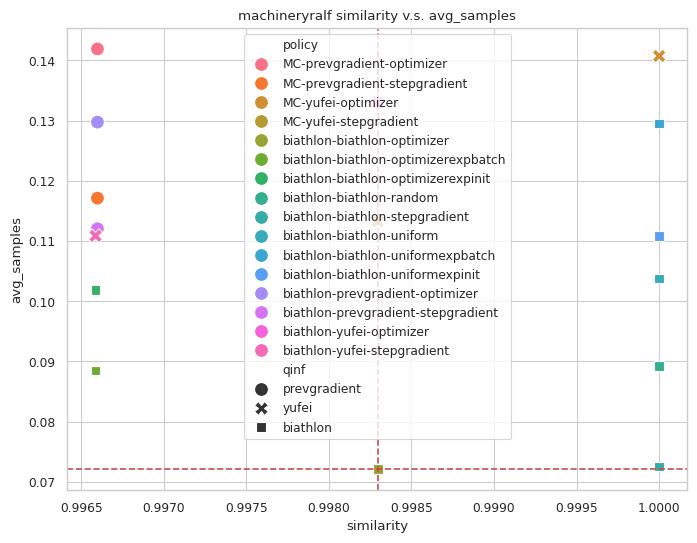

In [5]:
# plot the similarity v.s. avg_samples

sns.set_theme(style="whitegrid")
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(data=df, x='similarity', y='avg_samples', hue='policy', style='qinf', ax=ax, s=100)
# poliocy biathlon-biathlon-optimizer is ours, should be marked with a star and vertical line and horizontal line
biathlon_biathlon_optimizer = df.loc[('biathlon', 'biathlon', 'optimizer')]
ax.axvline(biathlon_biathlon_optimizer['similarity'], color='r', linestyle='--')
ax.axhline(biathlon_biathlon_optimizer['avg_samples'], color='r', linestyle='--')
# ax.scatter(biathlon_biathlon_optimizer['similarity'], biathlon_biathlon_optimizer['avg_samples'], marker='*', color='r', s=100)

plt.title(f'./cache/{task_name} similarity v.s. avg_samples')
plt.savefig(f'./cache/{task_name}_similarity_vs_avg_samples.png')
plt.show()